In [66]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

This notebook shows how we process images in the dataset to build the character dataset

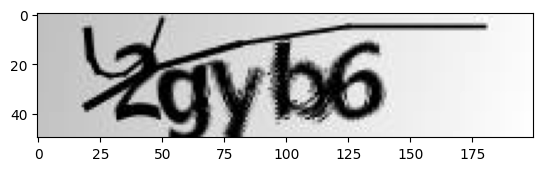

In [67]:

filename = '2gyb6.png'
#filename = 'y48c3.png'
img1 = cv2.imread('../samples/'+ filename, cv2.IMREAD_GRAYSCALE)

# Remove .png
filename = filename[:-4]

plt.imshow(img1, cmap='gray')

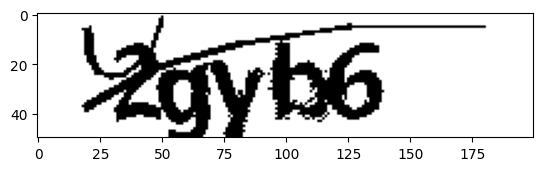

In [68]:
# images are in samples directory

img1_thr = cv2.threshold(img1, 127, 255, cv2.THRESH_BINARY)[1]

plt.imshow(img1_thr, cmap='gray')

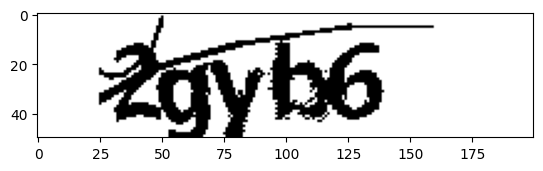

In [69]:
# remove useless stuff

img1_thr[:, 0:25] = 255

img1_thr[:, 160:] = 255

plt.imshow(img1_thr, cmap='gray')

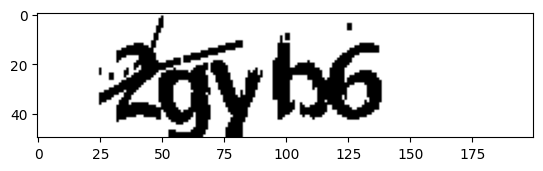

In [70]:
close_img1 = cv2.morphologyEx(img1_thr, cv2.MORPH_CLOSE, np.ones((3,1), np.uint8))

#close_img1 = cv2.dilate(close_img1, np.ones((3,1), np.uint8), iterations = 1)

plt.imshow(close_img1, cmap='gray')

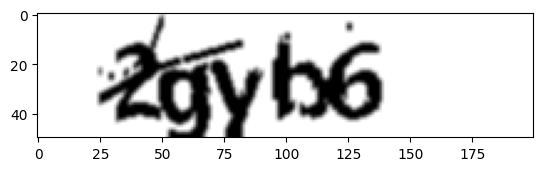

In [71]:
smooth = cv2.GaussianBlur(close_img1, (3,3), 0)

#sharp = cv2.addWeighted(smooth, 1.5, smooth, -0.5, 0)

plt.imshow(smooth, cmap='gray')

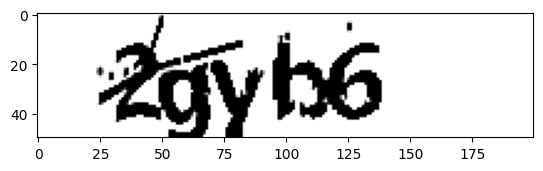

In [72]:
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv2.filter2D(smooth, -1, sharpen_kernel)

plt.imshow(sharpen, cmap='gray')


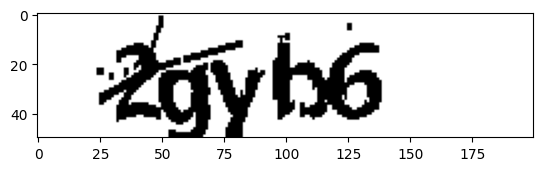

In [73]:
# thresholding
ret, thresh = cv2.threshold(sharpen, 185, 255, cv2.THRESH_BINARY)

plt.imshow(thresh, cmap='gray')

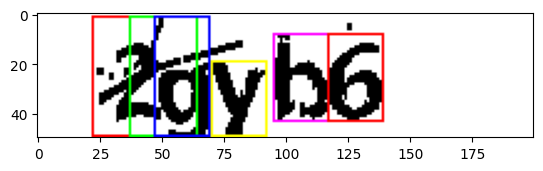

In [74]:
mser = cv2.MSER_create()

regions, rects = mser.detectRegions(thresh)

im2 = thresh.copy()
im2 = cv2.cvtColor(im2, cv2.COLOR_GRAY2RGB)

final_rects = []

for (x, y, w, h) in rects:
    if w > 135: continue
    elif w > 100:
        final_rects.append((x, y, w//5, h))
        final_rects.append((x + w//5, y, w//5, h))
        final_rects.append((x + 2 * w//5, y, w//5, h))
        final_rects.append((x + 3 * w//5, y, w//5, h))
        final_rects.append((x + 4 * w//5, y, w//5, h))
    elif w > 80:
        final_rects.append((x, y, w//4, h))
        final_rects.append((x + w//4, y, w//4, h))
        final_rects.append((x + 2 * w//4, y, w//4, h))
        final_rects.append((x + 3 * w//4, y, w//4, h))
    elif w > 50:
        final_rects.append((x, y, w//3, h))
        final_rects.append((x + w//3, y, w//3, h))
        final_rects.append((x + 2 * w//3, y, w//3, h))

    elif w > 35:
        final_rects.append((x, y, w//2, h))
        final_rects.append((x + w//2, y, w//2, h))
    else:
        final_rects.append((x, y, w, h))

# remove rectangles that contain only white pixels
final_rects = [rect for rect in final_rects if np.sum(thresh[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]) < 254 * rect[2] * rect[3]]

count = 0

# merge regions that are horizontally contained (take the area from the top left to the bottom right)
final_rects = [rect for rect in final_rects if not any([rect[0] > other_rect[0] and rect[1] > other_rect[1] and rect[0] + rect[2] < other_rect[0] + other_rect[2] and rect[1] + rect[3] < other_rect[1] + other_rect[3] for other_rect in final_rects if other_rect != rect])]


# Sort the rectangles by their x coordinate
final_rects = sorted(final_rects, key=lambda x: x[0])

count = 0

while count < 4 and len(final_rects) > 5:
    # check if the first two rectangles overlap
    if final_rects[count][0] + final_rects[count][2] > final_rects[count + 1][0]:

        x1 = final_rects[count][0]
        w1 = final_rects[count][2]
        x2 = final_rects[count + 1][0]
        w2 = final_rects[count + 1][2]

        if (final_rects[count + 1][0] - final_rects[count][0] < 10) or ((x2 + w2) < (x1 + w1) + 5):
            # if they do, merge them

            new_x = final_rects[count][0]
            new_y = min(final_rects[count][1], final_rects[count + 1][1])
            new_w = max(final_rects[count][0] + final_rects[count][2], final_rects[count + 1][0] + final_rects[count + 1][2]) - final_rects[count][0]
            new_h = max(final_rects[count][1] + final_rects[count][3], final_rects[count + 1][1] + final_rects[count + 1][3]) - min(final_rects[count][1], final_rects[count + 1][1])

            final_rects[count] = (new_x, new_y, new_w, new_h)
            # and remove the second one
            final_rects.pop(count + 1)
            continue

    count += 1

# remove rectangles with a height of less than 20 pixels
final_rects = [rect for rect in final_rects if (rect[3] > 20 and rect[2] > 10)]

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255,255,0), (255,0,255)]

# Draw the rectangles
for i, rect in enumerate(final_rects):
    cv2.rectangle(im2, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), colors[i % 5], 1)

plt.imshow(im2)